In [10]:
import sys
sys.path.append('/home/rrg0013@auburn.edu/git/nodules/src/')
import nodule
import scan
import lidc
import segment
import candgen as cg
import segutil

In [133]:
import SimpleITK as sitk
import pandas as pd
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import skimage.measure as measure
import copy

In [3]:
ANNOTATIONS_PATH = '/home/rrg0013@auburn.edu/git/nodules/resources/annotations.csv'
BIN0PATH = '/scr/data/nodules/luna/test/subset0/'
XMLDIR = '/home/rrg0013@auburn.edu/xml/'

In [172]:
annotations = pd.read_csv(ANNOTATIONS_PATH)
filelist, filepathlist = cg.getFilelist(BIN0PATH)
fuid = filelist[2]
currentNodules = annotations[annotations['seriesuid'] == fuid]
print currentNodules

                                            seriesuid     coordX     coordY  \
25  1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...  46.188539  48.402806   
26  1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...  36.392044  76.771663   

        coordZ  diameter_mm  
25 -108.578632    13.596471  
26 -123.321911     4.343200  


In [229]:
itk = sitk.ReadImage(filepathlist[2])
image = sitk.GetArrayFromImage(itk)
origin = np.array(list(reversed(itk.GetOrigin())))
spacing = np.array(list(reversed(itk.GetSpacing())))
iorigin = np.array(itk.GetOrigin())
ispacing = np.array(itk.GetSpacing())
coords = segment.getCoords(currentNodules,iorigin,ispacing)
scan = lidc.xml(XMLDIR,filelist[2],ispacing,iorigin)
scan.annotations = coords
lidc.cluster(scan)
scan.combine()
scan.validateNodules()

/home/rrg0013@auburn.edu/xml/
/home/rrg0013@auburn.edu/xml//1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059
[ 208.19544132  161.47205593  165.95504386]
[ 233.28684629  156.23046213   84.95076273]
[ 223.44291059  183.99794568   70.24463359]
[ 71.07322675  87.81248093  71.25      ]
[  55.9418412   146.47821619  121.31854839]
[  67.50584471  143.79293752  155.        ]
[ 225.5322534   109.42037248   87.51315789]
[  99.33786905  132.8163774   173.75      ]
[  94.947245    129.52340937  166.25      ]
[234 157  85]
85.0858017501
1.05033377972
VERIFIED NODULE
[224 185  71]
99.0949473068
33.2949786615
1.37296755042
VERIFIED NODULE
VALIDATED 2 OF 2 NODULES


In [230]:
def getImageMaskROI(scan, shape):
  print shape
  mask = np.zeros(shape)
  for nodule in scan.clusters:
    if nodule.valid:
      for coord in nodule.oroi:
        #print coord
        coord = np.round(np.asarray(coord[::-1])).astype(int)
        #print coord
        mask[coord[0],coord[1],coord[2]] += 1
  mask = np.clip(mask, 0, 1)
  for z in range(mask.shape[0]):
    slice = mask[z,:,:]
    slice[slice==0]=-1
    labels = measure.label(slice,connectivity=1)
    labels[labels==1]=0
    labels[labels>0]=1
    mask[z,:,:] = labels
  return mask

In [231]:
mask = getImageMaskROI(scan,image.shape)

(161, 512, 512)


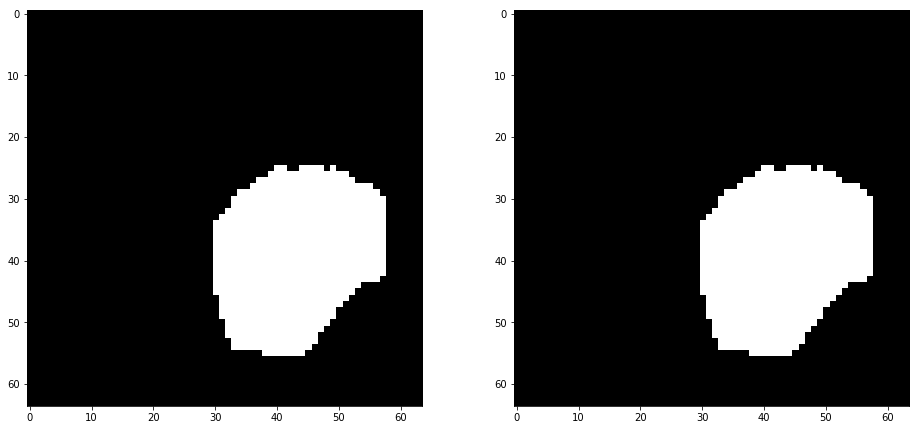

In [232]:
#slice = copy.deepcopy(mask[69,:,:])
#slice[slice==0]=-1
#labels = measure.label(slice,connectivity=1)
#labels[labels==1]=0
#labels[labels>0]=1
#print np.max(labels)
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.imshow(mask[69,278-32:278+32,415-32:415+32],cmap='gray')
plt.subplot(222)
plt.imshow(labels[278-32:278+32,415-32:415+32],cmap='gray')
plt.show()

In [233]:
newShape = image.shape * spacing
newShape = np.round(newShape)
szfactor = newShape / image.shape
image = scipy.ndimage.interpolation.zoom(image, szfactor, mode='nearest')

In [234]:
mask = scipy.ndimage.interpolation.zoom(mask, szfactor, mode='nearest')

In [235]:
np.sum(mask)

2162.9161150084815

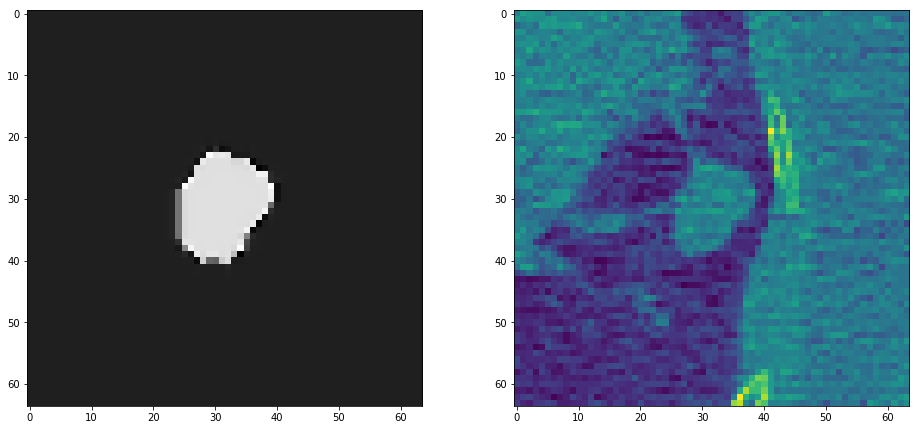

In [236]:
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.imshow(mask[coord[2],abs(coord[1])-32:abs(coord[1])+32,abs(coord[0])-32:abs(coord[0])+32],cmap='gray')
plt.subplot(222)
plt.imshow(image[coord[2],abs(coord[1])-32:abs(coord[1])+32,abs(coord[0])-32:abs(coord[0])+32])
plt.show()

In [237]:
mask[mask>5e-1]=1
mask[mask<=5e-1]=0

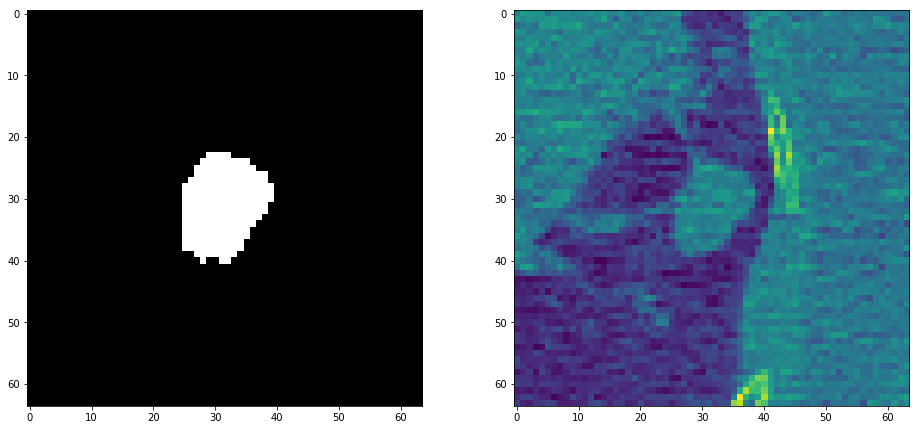

In [238]:
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.imshow(mask[coord[2],abs(coord[1])-32:abs(coord[1])+32,abs(coord[0])-32:abs(coord[0])+32],cmap='gray')
plt.subplot(222)
plt.imshow(image[coord[2],abs(coord[1])-32:abs(coord[1])+32,abs(coord[0])-32:abs(coord[0])+32])
plt.show()

In [284]:
tiroi = copy.deepcopy(image[coord[2]+6,abs(coord[1])-32:abs(coord[1])+32,abs(coord[0])-32:abs(coord[0])+32])
tmroi = copy.deepcopy(mask[coord[2]+6,abs(coord[1])-32:abs(coord[1])+32,abs(coord[0])-32:abs(coord[0])+32])

In [282]:
tiroi[tmroi==0]=0

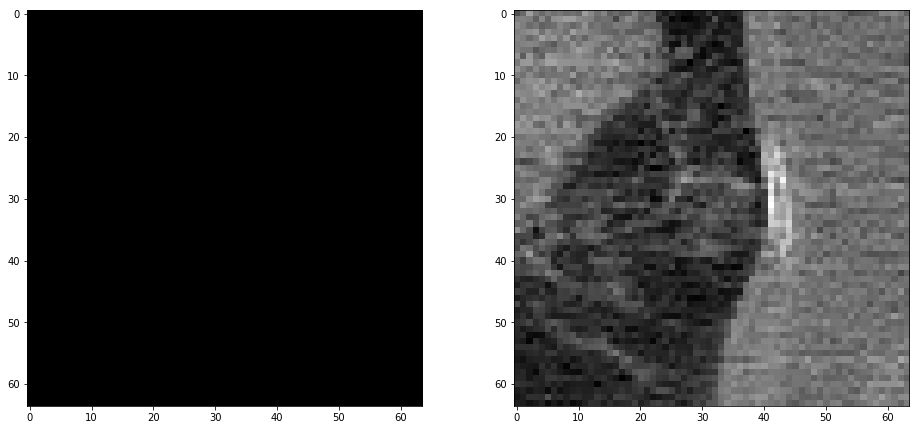

In [285]:
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.imshow(tmroi,cmap='gray')
plt.subplot(222)
plt.imshow(tiroi,cmap='gray')
plt.show()

In [287]:
annotations = currentNodules[['coordX','coordY','coordZ','diameter_mm']].as_matrix()

In [288]:
irois, mrois = segutil.getROIs(image, mask, iorigin, annotations)

In [290]:
count = 0
OUT_PATH = '/home/rrg0013@auburn.edu/'
for i in range(len(irois)):
  mroi = mrois[i]
  iroi = irois[i]
  fname = OUT_PATH+'/'+str(count)+'_image.png'
  scipy.misc.toimage(iroi[:,:],cmin=-1000,cmax=1000).save(fname)
  fname = OUT_PATH+'/'+str(count)+'_mask.png'
  scipy.misc.toimage(mroi[:,:],cmin=0,cmax=1).save(fname)
  count += 1

(512, 512)


IndexError: too many indices for array

In [40]:
print np.sum(mask)

7440877.07055
